In [1]:
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from rouge import Rouge
import requests
import google.generativeai as genai
import pandas as pd
import json
import sacrebleu
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import os

d:\leticia_abreu_DR4_TP3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Questão 4 - Meta Prompting para Análise de Sentimento

In [2]:
load_dotenv('../.env',
            override=True)

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

Classe criada para fazer scraping das manchetes do UOL

In [12]:
class UolScraping:
    def __init__(self, url):
        self.url = url
        
    def scraping(self):
        headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:133.0) Gecko/20100101 Firefox/133.0',
           'Connection' : 'keep-alive'}
        
        response = requests.get(url=self.url,
                        headers=headers)
        
        page_content = response.content

        soup = BeautifulSoup(page_content, 'html.parser')
        
        news_list = ['-' + tag.text for tag in soup.css.select('div[class="thumb-caption"]')]

        first_line = news_list[1:]

        each_line_phrase = '\n'.join(first_line)

        return each_line_phrase 
        

Pegando as manchetes

In [13]:
scraping = UolScraping('https://noticias.uol.com.br/')

headlines = scraping.scraping()

Metaprompt

In [14]:
metaprompt = '''
Crie um prompt de instrução para um LLM responsável por classificar manchetes de matérias jornalísticas.
Uma manchete pode ter somente uma das três categorias: positiva, neutra e negativa.
No prompt, você deve utilizar a estratégia de few-shot e dar múltiplos exemplos de manchetes para as três
categorias. O LLM deve esperar que cada linha é uma manchete diferente. Lembre-se: este é somente um 
prompt de instrução para o sistema. Você não deve criar manchetes e pedir, através do prompt, que elas 
sejam classificadas. Você não deve pedir no prompt coisas como: ensira as manchetes aqui, classifique 
as manchetes abaixo, entre outros. Lembre-se: o prompt que você irá criar é somente um prompt de instrução para o sistema.
Você deve dar uma persona adequada ao LLM.
Você deve informar através do prompt que a saída deve ser um objeto JSON, no formato 
[{"manchete" : "texto", "sentimento" : "classificação"},
{"manchete" : "texto", "sentimento" : "classificação"}, ...] 
'''

In [15]:
model = genai.GenerativeModel(model_name='gemini-1.5-flash')

Criação do prompt de instrução

In [16]:
response = model.generate_content(metaprompt)

new_prompt = response.text

print(new_prompt)

Você é um classificador de sentimentos especializado em analisar manchetes de notícias.  Seu trabalho é determinar se o sentimento geral expresso em cada manchete é positivo, negativo ou neutro.  Procure pelo sentimento principal, ignorando detalhes menores.  A saída deve ser um objeto JSON com o formato especificado abaixo.


**Formato de Saída:**

```json
[
  {"manchete": "texto da manchete", "sentimento": "positivo"|"neutro"|"negativo"},
  {"manchete": "texto da manchete", "sentimento": "positivo"|"neutro"|"negativo"},
  ...
]
```

**Exemplos:**

```
Manchete: "Economia Brasileira Cresce 2% no Último Trimestre" Sentimento: positivo
Manchete: "Novo Programa de Vacinação Contra a Gripe é Lançado" Sentimento: positivo
Manchete: "Governo Anuncia Aumento no Salário Mínimo" Sentimento: positivo
Manchete: "Acidente de Trânsito Deixa Vários Feridos" Sentimento: negativo
Manchete: "Preços dos Combustíveis Sobem Novamente" Sentimento: negativo
Manchete: "Crise Energética Ameaça o Abasteciment

Passando o prompt de instrução e normalizando a resposta

In [17]:
model = genai.GenerativeModel(
    "gemini-1.5-flash",
    system_instruction=new_prompt)

In [18]:
json_response = model.generate_content(headlines)

In [19]:
json_normalized = json_response.text.replace("```json\n",'').replace("\n```",'').replace("\n", "")

In [20]:
print(json_normalized)

[  {"manchete": "Reino Unido deportou mais de 600 brasileiros em voos 'secretos', diz The Guardian", "sentimento": "negativo"},  {"manchete": "Jogadores do Botafogo desfilam pelo Rio após levar a Libertadores", "sentimento": "positivo"},  {"manchete": "Sakamoto: Marinha sugere que só ela trabalha e o resto do país é 'come-dorme'", "sentimento": "negativo"},  {"manchete": "Juíza torna réus Vaccari, Marcelo Odebrecht e mais 37 investigados na antiga Lava Jato", "sentimento": "negativo"},  {"manchete": "Flávio Dino se casa na presença de ministros e desfila com camisa do Botafogo", "sentimento": "positivo"},  {"manchete": "Governo Bolsonaro pagou por viagens de engenheiro que questionou urnas", "sentimento": "negativo"},  {"manchete": "Verstappen celebra 'corrida inacreditável', e Red Bull brinca: 'Carma é maravilhoso'", "sentimento": "positivo"},  {"manchete": "Efraim Filho: Reforma tributária traz imposto sobre Faria Lima ou pequeno varejista?", "sentimento": "negativo"},  {"manchete": 

In [21]:
news_json = json_normalized

In [22]:
news_json = json.loads(news_json)

In [23]:
df = pd.DataFrame(news_json)

In [24]:
df.head()

,manchete,sentimento
0,Reino Unido deportou mais de 600 brasileiros e...,negativo
1,Jogadores do Botafogo desfilam pelo Rio após l...,positivo
2,Sakamoto: Marinha sugere que só ela trabalha e...,negativo
3,"Juíza torna réus Vaccari, Marcelo Odebrecht e ...",negativo
4,Flávio Dino se casa na presença de ministros e...,positivo


Criando um novo dataframe com a contagem de manchetes negativas, neutras e positivas

In [25]:
df_count = df.groupby(['sentimento']).size().reset_index(name='counts')

In [26]:
df_count.head()

,sentimento,counts
0,negativo,14
1,neutro,3
2,positivo,6


Criando o gráfico com seaborn

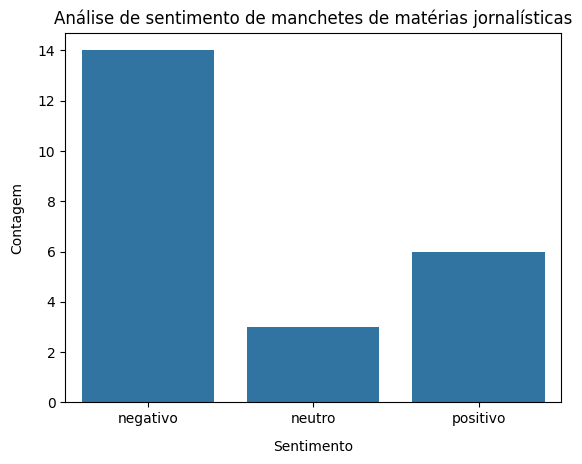

In [27]:
fig = sns.barplot(data=df_count,
            y=df_count['counts'],
            x=df_count['sentimento']
            )

plt.xlabel('Sentimento',
           labelpad=10.0)
plt.ylabel('Contagem',
           labelpad=10.0)
plt.title('Análise de sentimento de manchetes de matérias jornalísticas')

plt.show(fig)

## Questão 5 - Base de dados The Simpsons

Criando a tabela unificada

In [9]:
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))

Carregando os arquivos CSV

In [10]:
df_script = pd.read_csv(os.path.join(DATA_PATH, 'simpsons_script_lines.csv'),
                        low_memory=False,
                        quotechar='"',
                        )
                        
df_episodes = pd.read_csv(os.path.join(DATA_PATH, 'simpsons_episodes.csv'),
                        low_memory=False)
                          
df_characters = pd.read_csv(os.path.join(DATA_PATH, 'simpsons_characters.csv'),
                        low_memory=False,
                        quotechar='"')
                            
df_locations = pd.read_csv(os.path.join(DATA_PATH, 'simpsons_locations.csv'), 
                        low_memory=False,
                        quotechar='"'
                        )     

Juntando os dataframes

In [11]:
df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)


assert data.shape[0] == df_script.shape[0]

In [12]:
data.head().T

,0,1,2,3,4
episode_id,32,32,32,32,32
number,209,210,211,212,213
raw_text,"Miss Hoover: No, actually, it was a little of ...",Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,Miss Hoover: I don't know. Although I'd sure l...,Lisa Simpson: That life is worth living.,Edna Krabappel-Flanders: The polls will be ope...
timestamp_in_ms,848000,856000,856000,864000,864000
speaking_line,true,true,true,true,true
character_id,464,9,464,9,40
location_id,3.0,3.0,3.0,3.0,3.0
raw_character_text,Miss Hoover,Lisa Simpson,Miss Hoover,Lisa Simpson,Edna Krabappel-Flanders
raw_location_text,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School,Springfield Elementary School
spoken_words,"No, actually, it was a little of both. Sometim...",Where's Mr. Bergstrom?,I don't know. Although I'd sure like to talk t...,That life is worth living.,The polls will be open from now until the end ...


Função para calcular o número de tokens

In [27]:
def estimar_tokens(texto):
    encoder = tiktoken.get_encoding("cl100k_base")  # Exemplo de codificação
    # encoder = tiktoken.get_encoding("gpt-4o")  # Exemplo de codificação
    tokens = encoder.encode(texto)
    return tokens

In [13]:
X = data.dropna(subset='normalized_text').copy()

Fazendo um subset do dataframe original contendo somente o id do episodio, da season, e as falas

In [21]:
X_subset_text = X[['episode_id', 'episode_season', 'normalized_text']].copy()
X_subset_text.head()

,episode_id,episode_season,normalized_text
0,32,2,no actually it was a little of both sometimes ...
1,32,2,wheres mr bergstrom
2,32,2,i dont know although id sure like to talk to h...
3,32,2,that life is worth living
4,32,2,the polls will be open from now until the end ...


Aplicando a função de cálculo de tokens

In [35]:
X_subset_text['n_tokens'] = X_subset_text.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))
X_subset_text.head()

,episode_id,episode_season,normalized_text,n_tokens
0,32,2,no actually it was a little of both sometimes ...,31
1,32,2,wheres mr bergstrom,5
2,32,2,i dont know although id sure like to talk to h...,22
3,32,2,that life is worth living,5
4,32,2,the polls will be open from now until the end ...,33


Criando um subset só com episódio, season e número de tokens

In [45]:
X_subset_tokens_ep = X_subset_text.groupby(['episode_id', 'episode_season'])['n_tokens'].sum().to_frame()

X_subset_tokens_ep.head()

,,n_tokens
episode_id,episode_season,
1,1,3246
2,1,3029
3,1,2535
4,1,2995
5,1,2788


Calculando o número médio de tokens por episódio

In [48]:
media_ep = X_subset_tokens_ep['n_tokens'].mean()

print(f'O número médio de tokens por episódio é de {int(media_ep)} tokens')

O número médio de tokens por episódio é de 2606 tokens


Criando um subset só com season e número de tokens

In [49]:
X_subset_tokens_season = X_subset_text.groupby(['episode_season'])['n_tokens'].sum().to_frame()

X_subset_tokens_season.head()

,n_tokens
episode_season,
1,36865
2,65525
3,69455
4,53171
5,58860


Calculando o número médio de tokens por season

In [50]:
media_season = X_subset_tokens_season['n_tokens'].mean()

print(f'O número médio de tokens por season é de {int(media_season)} tokens')

O número médio de tokens por season é de 56551 tokens


Episódio com maior número de tokens:

In [51]:
X_subset_tokens_ep[X_subset_tokens_ep['n_tokens'] == X_subset_tokens_ep['n_tokens'].max()]

,,n_tokens
episode_id,episode_season,
49,3,3454


Temporada com maior número de tokens:

In [52]:
X_subset_tokens_season[X_subset_tokens_season['n_tokens'] == X_subset_tokens_season['n_tokens'].max()]

,n_tokens
episode_season,
7,70418


Vamos plotar em um gráfico de barras o número de tokens por temporada para saber se a season 7 foi um outlier

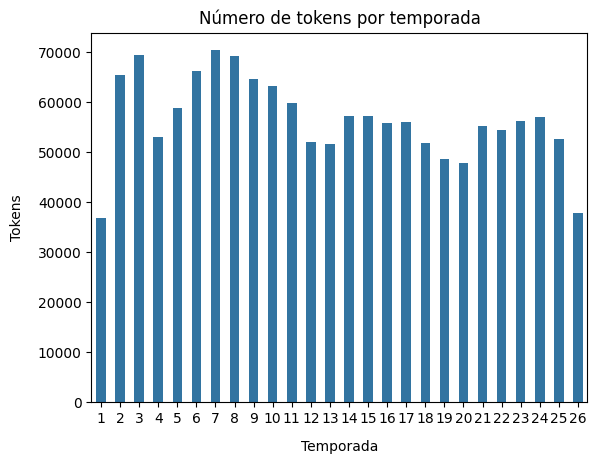

In [63]:
fig, ax = plt.subplots()

fig = sns.barplot(
    data=X_subset_tokens_season,
    x='episode_season',
    y='n_tokens',
    width=0.5
)

ax.set_xlabel('Temporada',
           labelpad=10.0)

ax.set_ylabel('Tokens',
           labelpad=10.0)

ax.set_title('Número de tokens por temporada')

plt.show(fig)

A season 7 não é um outlier, com as temporadas 3, 5 e 8 apresentando um número parecido de tokens. O gráfico apresenta uma clara tendência de diminuição do número de tokens ao longo das temporadas do show, o que pode ser reflexo de várias coisas: redução do número de episódios por temporada, episódios mais curtos e com menos falas, ou até mesmo deficiência de dados no dataset em relação às temporadas mais recentes

Vamos plotar em um gráfico de barras os episódios da 3 temporada, para saber se o episódio com maior número de tokens é um outlier em relação aos demais episódios da mesma temporada

Filtrando os episódios para somente aqueles da 3 temporada

In [66]:
X_subset_tokens_ep_season_3 = X_subset_tokens_ep.query('episode_season == 3')

X_subset_tokens_ep_season_3.head()

,,n_tokens
episode_id,episode_season,
36,3,3249
37,3,2901
38,3,3090
39,3,2791
40,3,3144


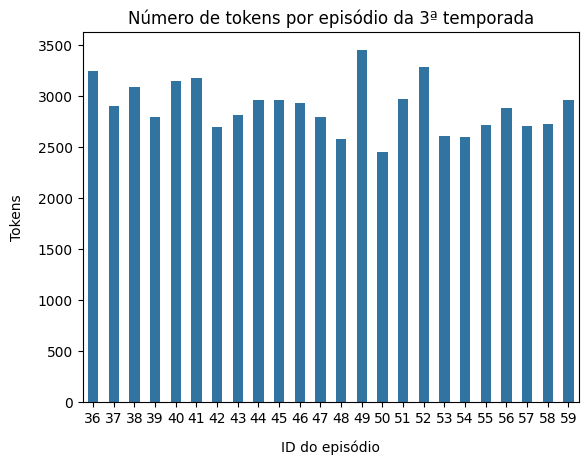

In [68]:
fig, ax = plt.subplots()

fig = sns.barplot(
    data=X_subset_tokens_ep_season_3,
    x='episode_id',
    y='n_tokens',
    width=0.5
)

ax.set_xlabel('ID do episódio',
           labelpad=10.0)

ax.set_ylabel('Tokens',
           labelpad=10.0)

ax.set_title('Número de tokens por episódio da 3ª temporada')

plt.show(fig)

Na questão de número de tokens por episódio na 3ª temporada, não parece existir uma tendência ou padrão, os valores flutuam de episódio para episódio. Por exemplo, após o episódio de ID 49, que possui o maior número de tokens, vem o episódio de ID 50, que possui o menor número de tokens na temporada. A variabilidade no número de tokens pode ser devido a diferenças no conteúdo, diálogo ou narrativa usada em cada episódio individual, em vez de uma mudança editorial ou de produção consistente ao longo da temporada.

Usando Prompt Chaining para análise da base de dados dos Simpsons

In [70]:
cols = ['episode_id', 'episode_season','episode_original_air_date', 'episode_imdb_rating', 
        'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']
episode_stats = data[cols].drop_duplicates()

episode_stats.to_csv(os.path.join(DATA_PATH,'series_data.csv'), sep=';', index=None)

Prompt_inicial para o LLM criar os tipos de análises

In [75]:
prompt_inicial = '''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed 
Make a list of 5 types of analysis that can be implemented with the available data, in JSON format, following the example below: 

### EXAMPLE
 
{[ {'Name':'Analysis name', 'Objective': 'What we need to analyze', 'Method': 'How we will analyze' } ] }
'''

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_inicial)
analysis = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
analysis

[{'Name': 'Correlation between IMDB Rating and Viewership',
  'Objective': "Determine if there's a relationship between IMDB rating and the number of US viewers or total views.",
  'Method': "Calculate the Pearson correlation coefficient between 'episode_imdb_rating' and both 'episode_us_viewers_in_millions' and 'episode_views'.  Visualize the relationship using scatter plots."},
 {'Name': 'Impact of Season on Ratings and Viewership',
  'Objective': 'Analyze how ratings and viewership change across different seasons of the show.',
  'Method': "Group data by 'episode_season' and calculate the average 'episode_imdb_rating', 'episode_us_viewers_in_millions', and 'episode_views' for each season. Visualize the trends using line graphs."},
 {'Name': 'Relationship between IMDB Votes and Ratings',
  'Objective': "Investigate if the number of IMDB votes influences the episode's rating.",
  'Method': "Create a scatter plot of 'episode_imdb_votes' vs 'episode_imdb_rating'. Calculate the correlati

In [87]:
prompt_analises = f'''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed
The path to the csv file is stated below:

## PATH
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
os.path.join(DATA_PATH,'series_data.csv')

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[0]}
'''

In [88]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analises)
print(response.text)

```python
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
DATA_FILE = os.path.join(DATA_PATH,'series_data.csv')

df = pd.read_csv(DATA_FILE, delimiter=';')

#correlation between IMDB rating and US viewers
correlation, p_value = pearsonr(df['episode_imdb_rating'], df['episode_us_viewers_in_millions'])
print(f"Correlation between IMDB rating and US viewers: {correlation:.2f}, p-value: {p_value:.3f}")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='episode_imdb_rating', y='episode_us_viewers_in_millions', data=df)
plt.title('IMDB Rating vs. US Viewers')
plt.show()

#correlation between IMDB rating and total views
correlation, p_value = pearsonr(df['episode_imdb_rating'], df['episode_views'])
print(f"Correlation between IMDB rating and total views: {correlation:.2f}, p-value: {p_value:.3f}")
plt.figure(figsize=(8, 6))
sns.scatterplot(x='episode_imdb_rating', y='episod

Análise 1

Correlation between IMDB rating and US viewers: nan, p-value: nan


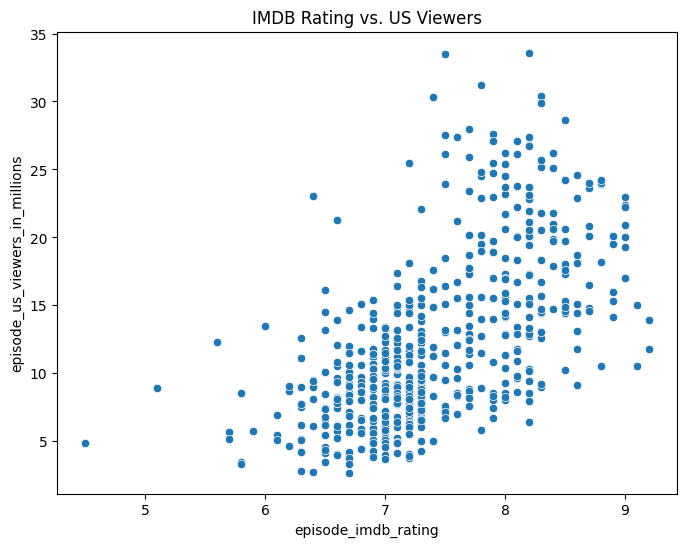

Correlation between IMDB rating and total views: 0.59, p-value: 0.000


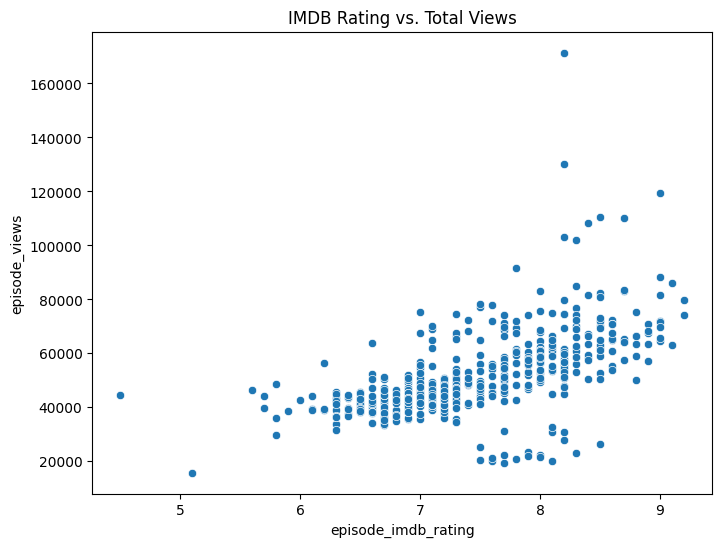

In [90]:
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [92]:
prompt_analises = f'''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed
The path to the csv file is stated below:

## PATH
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
os.path.join(DATA_PATH,'series_data.csv')

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[1]}
'''

Análise 2

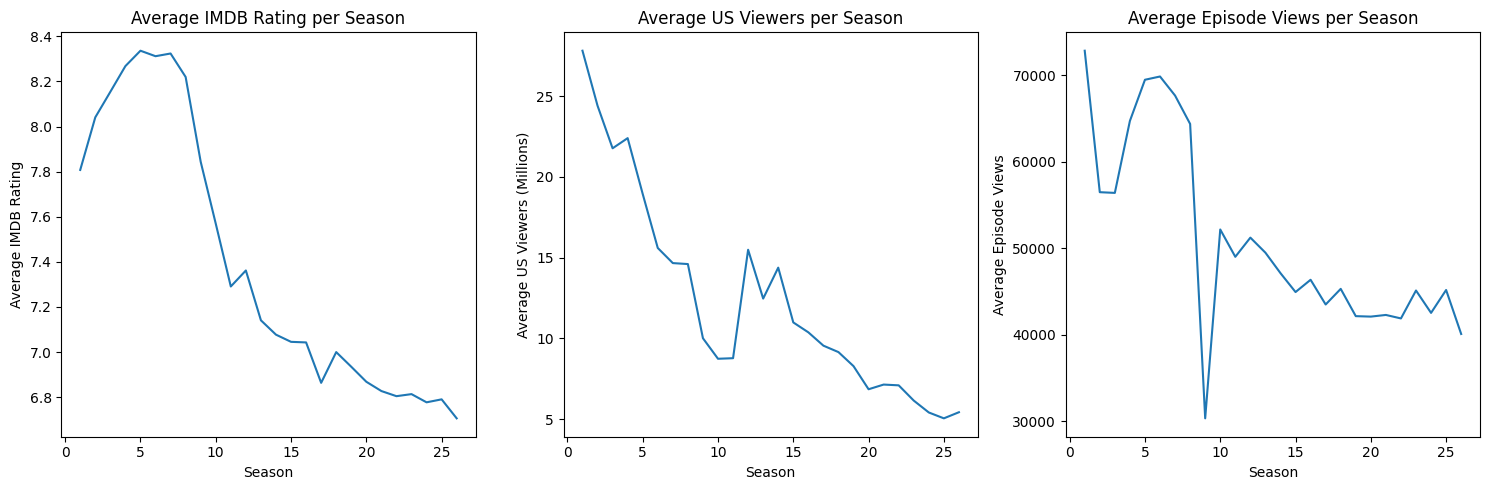

In [93]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analises)
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [94]:
prompt_analises = f'''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed
The path to the csv file is stated below:

## PATH
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
os.path.join(DATA_PATH,'series_data.csv')

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[2]}
'''

Análise 3

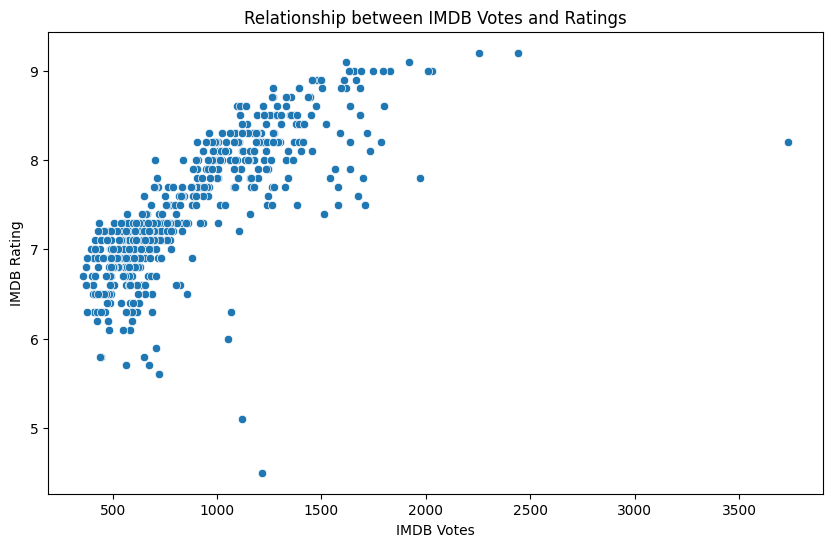

Correlation coefficient: 0.7805560770639186


In [95]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analises)
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [96]:
prompt_analises = f'''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed
The path to the csv file is stated below:

## PATH
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
os.path.join(DATA_PATH,'series_data.csv')

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[3]}
'''

Análise 4

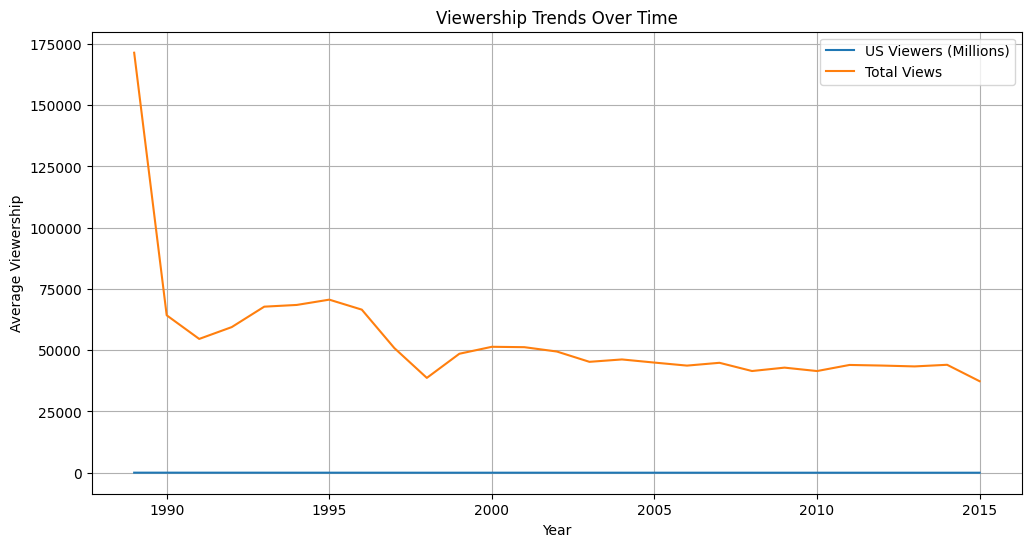

In [97]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analises)
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

In [105]:
prompt_analises = f'''
You are a data scientist working for the entertainment network FOX. Your task is to analyze patterns and trends in the show "The Simpsons".
Specifically, you are to analyze the relationships between ratings, which are in the following columns of the csv file containing the show's 
data: ('episode_imdb_rating', 'episode_imdb_votes'), and viewership, which are in the following columns of the csv file: ('episode_us_viewers_in_millions', 'episode_views').
Consider that the delimiter of the csv file is ';' and the information that each column has is: 
- episode_id: Unique identifier of the episode 
- episode_season: Season number 
- episode_original_air_date: Date the episode was originally aired 
- episode_imdb_rating: Episode with IMDB rating 
- episode_imdb_votes: Episode with number of IMDB votes 
- episode_us_viewers_in_millions: Number of viewers (in millions) 
- episode_views: Total number of times the episode was viewed
The path to the csv file is stated below:

## PATH
DATA_PATH = os.path.abspath(os.path.join('..', 'data'))
os.path.join(DATA_PATH,'series_data.csv')

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[4]}
'''

Análise 5

In [106]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analises)
analysis_code = response.text.replace("```python\n",'').replace("\n```",'')
exec(analysis_code)

Viewers in Millions - RMSE: 3.9132884369943954
Viewers in Millions - R-squared: 0.6769715529716784
Episode Views - RMSE: 15571.302462502888
Episode Views - R-squared: 0.3387152466252764


O LLM gerou análises relevantes para a base de dados dos Simpsons. O LLM gerou sem problemas os códigos para as análises 1, 2 e 3. Nas análises 4 e 5, porém, o resultado não foi tão satisfatório. Por exemplo, na análise "Analyze how viewership (both US viewers and total views) has changed over the years", a linha representando US Viewers não reflete os dados. Isso pode estar relacionado ao fato de, no arquivo csv, o número de visualizações por milhões ser representado por números decimais (como 17.7), e no código gerado pelo LLM, esses valores não foram multiplicados por 1.000.000. Na análise 5, "Build a model to predict viewership based on IMDB rating and season", o modelo gerado pelo LLM para predizer o número de espectadores nos Estados Unidos(episode_us_viewers_in_millions) parece ter um ajuste razoavelmente bom, explicando cerca de 67,7% da variância. Já para o número total de visualizações por episódio(episode_views) o ajuste do modelo é mais fraco, explicando apenas cerca de 33,9% da variância.

## Questão 6 - Classificação de Sentimento com Few-Shot Learning

Filtrando as falas para somente aquelas do episódio de id 92

In [23]:
X_subset_text_id92 = X_subset_text.query('episode_id == 92')
X_subset_text_id92

,episode_id,episode_season,normalized_text
17424,92,5,cant talk robbed go hell
17439,92,5,dad weve been robbed
17440,92,5,wake up dad wake up there was a burglar and he...
17441,92,5,woo hoo
17442,92,5,and our portable tv
...,...,...,...
17709,92,5,hmmm i guess were not gonna find anything
17710,92,5,uh howre we gonna get outta here
17711,92,5,well dig our way out
17712,92,5,no no dig up stupid


Pegando todas as falas do episódio

In [25]:
dialogue_list = X_subset_text_id92['normalized_text'].to_list()
dialogue_list

['cant talk robbed go hell',
 'dad weve been robbed',
 'wake up dad wake up there was a burglar and he took my saxophone',
 'woo hoo',
 'and our portable tv',
 'and my necklace',
 'eh thats no big loss',
 'homer that necklace was a priceless bouvier family heirloom',
 'oh youve probably got a whole drawer full of em',
 'well yes i do but theyre all heirlooms too',
 'the burglar even took my stamp collection',
 'you had a stamp collection',
 'stamp collection haw haw',
 'barts pain is funny but mine isnt that saxophone was my one creative outlet it was the only way i could truly express myself',
 'shhh quiet lisa',
 'hey the burglar left his calling card',
 'you have just been robbed by the springfield cat burglar cute',
 'hidilly ho neighboreenos',
 'you folks got robbed too the burglar took my shroud of turin beach towels',
 'wow its a crime wave',
 'good lord my stormin norman commemorative plates stolen again',
 'hey i thought i had more stuff than this',
 'we are insured arent we m

Transformando em string

In [133]:
dialogue_string = "\n".join(dialogue_list)
print(dialogue_string)

cant talk robbed go hell
dad weve been robbed
wake up dad wake up there was a burglar and he took my saxophone
woo hoo
and our portable tv
and my necklace
eh thats no big loss
homer that necklace was a priceless bouvier family heirloom
oh youve probably got a whole drawer full of em
well yes i do but theyre all heirlooms too
the burglar even took my stamp collection
you had a stamp collection
stamp collection haw haw
barts pain is funny but mine isnt that saxophone was my one creative outlet it was the only way i could truly express myself
shhh quiet lisa
hey the burglar left his calling card
you have just been robbed by the springfield cat burglar cute
hidilly ho neighboreenos
you folks got robbed too the burglar took my shroud of turin beach towels
wow its a crime wave
good lord my stormin norman commemorative plates stolen again
hey i thought i had more stuff than this
we are insured arent we mom
homer tell your child what you bought when i sent you to town to get some insurance
cur

Criando o prompt

In [134]:
prompt_sentiment_analysis = f'''
You are a speech sentiment analysis expert for The Simpsons. You are working on a specific episode, named "Homer the Vigilante"
Your job is to determine whether the overall sentiment expressed in each dialogue of the episode is positive, negative, or neutral.
Look for the main sentiment, ignoring minor details. The output should be a JSON object with the format specified below. To guide you,
check the <examples> with pre-classified dialogues from the episode. The <dialogues> that you will classify is a string with each line
representing one diferent dialogue.

**Output format:**

```json
[
  "dialogue": "dialogue text", "sentiment": "positive"|"neutral"|"negative",
  "dialogue": "dialogue text", "sentiment": "positive"|"neutral"|"negative",
  ...
]
```

<examples>

**negative**

-dad weve been robbed
-and i still dont have my saxophone
-wake up dad wake up there was a burglar and he took my saxophone
-oh grampa they pelted you too

**positive**

-aw dad i could kiss you
-youre so good
-oh hes so charming
-youre the man homer

**neutral**

-what this jug
-come with me
-well be right back
-abe can i use your ointment

</examples>

<dialogues>

{dialogue_string}

</dialogues>
'''

In [135]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_sentiment_analysis)
print(response.text)

```json
[
  {"dialogue": "cant talk robbed go hell", "sentiment": "negative"},
  {"dialogue": "dad weve been robbed", "sentiment": "negative"},
  {"dialogue": "wake up dad wake up there was a burglar and he took my saxophone", "sentiment": "negative"},
  {"dialogue": "woo hoo", "sentiment": "positive"},
  {"dialogue": "and our portable tv", "sentiment": "negative"},
  {"dialogue": "and my necklace", "sentiment": "negative"},
  {"dialogue": "eh thats no big loss", "sentiment": "neutral"},
  {"dialogue": "homer that necklace was a priceless bouvier family heirloom", "sentiment": "negative"},
  {"dialogue": "oh youve probably got a whole drawer full of em", "sentiment": "neutral"},
  {"dialogue": "well yes i do but theyre all heirlooms too", "sentiment": "neutral"},
  {"dialogue": "the burglar even took my stamp collection", "sentiment": "negative"},
  {"dialogue": "you had a stamp collection", "sentiment": "neutral"},
  {"dialogue": "stamp collection haw haw", "sentiment": "positive"},
 

In [ ]:
json_normalized = response.text.replace("```json\n",'').replace("\n```",'').replace("\n", "")

json_normalized = json.loads(json_normalized)

df_sentiment = pd.DataFrame.from_dict(json_normalized)

df_sentiment.head()

In [148]:
df_sentiment_count = df_sentiment.groupby(['sentiment']).size().reset_index(name='counts')

df_sentiment_count.head()


,sentiment,counts
0,negative,77
1,neutral,115
2,positive,52


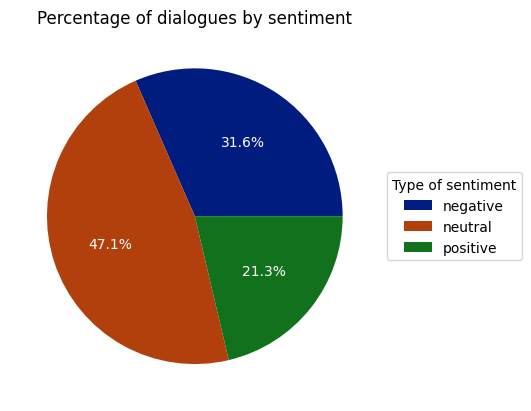

In [161]:
fig, ax = plt.subplots()

colors = sns.color_palette('dark')

ax.pie(df_sentiment_count['counts'],
       autopct='%1.1f%%',
       colors=colors,
       textprops=dict(color='w'))

ax.legend(df_sentiment_count['sentiment'],
          title='Type of sentiment',
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Percentage of dialogues by sentiment',
             loc='center')

plt.show(fig)

## Questão 7 - Resumo Episódio

In [36]:
resumo = '''
The episode begins with an unidentified burglar entering the Simpsons house at night and stealing multiple objects,
like Lisa's saxophone, Marge's pearl collar and a portable TV. In the morning, the Simpsons notice the missing objects,
and find that the burglar left his business card. Ned flanders and multiple Springfield residents also have been robbed.
Homer calls the police, who do nothing. The attempt of the police chief Wiggum in tracking the burglar is unsuccessful.
The Springfield residents begin to install home security equipment. Lisa is still sad about losing her saxophone, which
moves Homer into doing something. Ned Flanders suggests the creation of a vigilante group, and Homer becomes its leader.
Homer's vigilante group proves to be unsuccessful in catching the burglar, and is abusing power, harassing the neighborhood.
Lisa and Marge point to the abuse of power of the vigilante group. Homer goes to the local TV News to talk about the actions
of the vigilante group, when the burglar makes a phone call and taunts Homer, saying that he has Lisa's saxophone and Marge's
necklace. The burglar also says that he will steal the Springfield museum cubic zirconia.
Homer's vigilante group attempts to watch over the museum, but Homer gets drunk and the cubic zirconia is robbed. The whole town
is mad at Homer because of his failure, and the vigilante group falls apart. Grandpa Simpson goes to Homer's house and tells the
family that he discovered who is the burglar: Molloy, a colleague from the retirement home. All the town goes to the retirement home
to catch Molloy, who apologizes and returns the stolen items. In the prison, Molloy tells Homer, police chief Wiggum and other officers
that he hid millions of dollars, "under a big T". This leads the whole town in a treasure hunt. Molloy's instructions lead them to a tree
with the shape of a T. They dig the site and only find a message from Molloy saying that the treasure hunt was only a trick to escape prison.
'''
# Quebrando a string e depois juntando para melhor visualização.
resumo = resumo.replace('\n', '')

tokens =  estimar_tokens(resumo)

print(f'Meu resumo teve aproximadamente {len(tokens)} tokens')

Meu resumo teve aproximadamente 423 tokens


## Questão 8 - Resumos Complexos com Chunks de Texto

In [14]:
X_subset_dialogue = X[['episode_id', 'character_normalized_name','location_normalized_name', 'normalized_text']].query('episode_id == 92').copy()

Filtrando somente o episódio de id 92

In [15]:
X_subset_dialogue.drop(columns=['episode_id'], inplace=True)

X_subset_dialogue.reset_index(drop=True, inplace=True)

X_subset_dialogue.head()

,character_normalized_name,location_normalized_name,normalized_text
0,homer simpson,simpson home,cant talk robbed go hell
1,bart simpson,simpson home,dad weve been robbed
2,lisa simpson,simpson home,wake up dad wake up there was a burglar and he...
3,homer simpson,simpson home,woo hoo
4,bart simpson,simpson home,and our portable tv


Criando uma lista de diálogos, onde cada item da lista é um único diálogo

In [16]:
dialogue_ep_id92 = ''

for i in range(len(X_subset_dialogue)):
    dialogue_ep_id92 += " ".join(X_subset_dialogue.iloc[i].astype(str)) + '\n'

dialogue_ep_id92 = dialogue_ep_id92.split('\n')

dialogue_ep_id92[0:10]

['homer simpson simpson home cant talk robbed go hell',
 'bart simpson simpson home dad weve been robbed',
 'lisa simpson simpson home wake up dad wake up there was a burglar and he took my saxophone',
 'homer simpson simpson home woo hoo',
 'bart simpson simpson home and our portable tv',
 'marge simpson simpson home and my necklace',
 'homer simpson simpson home eh thats no big loss',
 'marge simpson simpson home homer that necklace was a priceless bouvier family heirloom',
 'homer simpson simpson home oh youve probably got a whole drawer full of em',
 'marge simpson simpson home well yes i do but theyre all heirlooms too']

Alterando a classe ChunkSummary para a mesma trabalhar com uma lista no input, não uma string

In [18]:
class ChunkSummary():
    def __init__(self, model_name, apikey, dialogues, window_size, overlap_size):
        # Garante que os diálogos sejam uma lista
        self.dialogues = dialogues if isinstance(dialogues, list) else [dialogues]
        self.window_size = window_size
        self.overlap_size = overlap_size
        
        # Criar chunks de diálogos
        self.chunks = self.__dialogues_to_chunks()
        
        # Criar modelo
        self.model = self.__create_model(apikey, model_name)

    def __create_model(self, apikey, model_name):
        genai.configure(api_key=apikey)
        
        self.prompt_base = f"""
        You are an editor assistant analyzing dialogue chunks.
        You will receive dialogue lines from a conversation or script.
        
        Create a summary of the dialogues, highlighting:
        - Key speakers
        - Most important conversation points
        - Context and progression of the dialogue
        - Significant interactions or revelations
        
        The summary output must be a clear, concise JSON with a 'summary' field.
        """
        
        safety_settings = {
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }
        
        generation_config = {
            'temperature': 0.2,
            'top_p': 0.8,
            'top_k': 20,
            'max_output_tokens': 1000
        }
        
        return genai.GenerativeModel(
            model_name,
            system_instruction=self.prompt_base,
            generation_config=generation_config,
            safety_settings=safety_settings
        )

    def __dialogues_to_chunks(self):
        """
        Cria chunks de diálogos com tamanhos de janela e sobreposição especificados
        
        Args:
            window_size (int): Número de diálogos em cada chunk
            overlap_size (int): Número de diálogos para sobrepor entre chunks
        
        Returns:
            Lista de chunks de diálogos
        """
        n = self.window_size  # Tamanho de cada chunk
        m = self.overlap_size  # Sobreposição entre chunks
        
        # Criar chunks com janela e sobreposição especificadas
        return [self.dialogues[i:i+n] for i in range(0, len(self.dialogues), n-m)]

    def __create_chunk_prompt(self, chunk):
        """
        Cria um prompt para um chunk de diálogos
        
        Args:
            chunk (list): Lista de diálogos no chunk atual
        
        Returns:
            str: Prompt formatado para o chunk de diálogos
        """
        # Converter cada diálogo para uma string formatada
        chunk_lines = '\n'.join(str(dialogue) for dialogue in chunk)
        
        prompt = f"""
        Dialogue Chunk:
        {chunk_lines}
        
        Summarize the key points and interactions in this dialogue chunk.
        """
        return prompt
    
    def __summarize_chunks(self):
        """
        Resumir cada chunk de diálogos
        
        Returns:
            list: Resumos para cada chunk de diálogos
        """
        chunk_summaries = []
        
        for i, chunk in enumerate(self.chunks):
            print(f'Summarizing chunk {i+1} from {len(self.chunks)}')
            
            # Criar e processar prompt para o chunk
            prompt = self.__create_chunk_prompt(chunk)
            response = self.model.generate_content(prompt)
            
            chunk_summaries.append(response.text)
        
        return chunk_summaries

    def summarize(self, return_chunk_summaries=True):
        """
        Realizar sumarização final em todos os chunks de diálogos
        
        Args:
            return_chunk_summaries (bool): Se deve retornar os resumos dos chunks
        
        Returns:
            dict ou str: Dicionário com resumos dos chunks e resumo final, 
                         ou apenas resumo final dependendo do parâmetro
        """
        print('Summarizing dialogues')
        
        # Obter resumos para cada chunk
        self.chunk_summaries = self.__summarize_chunks()
        
        # Formatar resumos dos chunks para sumarização final
        summaries = '- ' + '\n- '.join(self.chunk_summaries)
        
        # Criar prompt de sumarização final
        final_prompt = f"""
        You are a comprehensive editor tasked with creating an overarching summary
        of dialogues across multiple chunks. Consider the following partial summaries:
        
        {summaries}
        
        Generate a holistic summary that captures:
        - Overall narrative flow
        - Key interactions and developments
        - Significant themes or insights
        
        Provide the summary in a clear JSON format with a 'summary' field.
        """
        
        print('Generating final summary')
        response = self.model.generate_content(final_prompt)
        
        # Armazenar resumo final
        self.final_summary = response.text
        
        # Retornar de acordo com o parâmetro
        if return_chunk_summaries:
            return {
                'chunk_summaries': self.chunk_summaries,
                'final_summary': self.final_summary
            }
        else:
            return self.final_summary

In [19]:
summarizer = ChunkSummary(model_name='gemini-1.5-flash',
             apikey=os.environ["GOOGLE_API_KEY"],
             dialogues=dialogue_ep_id92,
             window_size=100,
             overlap_size=25)

episode_summary = summarizer.summarize()

Summarizing dialogues
Summarizing chunk 1 from 4
Summarizing chunk 2 from 4
Summarizing chunk 3 from 4
Summarizing chunk 4 from 4
Generating final summary


In [20]:
final_summary = json.loads(episode_summary['final_summary'].replace("```json\n",'').replace("\n```",''))

final_summary['summary']

"The overarching narrative follows Homer Simpson's accidental and ultimately unsuccessful involvement in a series of events triggered by a cat burglar's spree in Springfield.  It begins with the burglar stealing various items from the Simpsons' home and other residents, sparking a city-wide panic and Chief Wiggum's ineffective investigation.  Homer, initially apathetic, forms a vigilante group after a misunderstanding about gun ownership, recruiting various Springfield residents.  This group's actions escalate from minor infractions to heavy-handed enforcement, causing more chaos.  A subplot involves Homer's encounter with a beatnik and a miniature A-bomb.  The group's ineptitude is highlighted by their failure to catch the burglar, Molloy, who is revealed to be charming and remorseful.  Grampa Simpson unexpectedly plays a key role in identifying Molloy, a resident of his retirement home.  Molloy's vague directions about buried treasure lead to a town-wide, ultimately fruitless, treasu

Resumo do episódio:

"The overarching narrative follows Homer Simpson's accidental and ultimately unsuccessful involvement in a series of events triggered by a cat burglar's spree in Springfield.  It begins with the burglar stealing various items from the Simpsons' home and other residents, sparking a city-wide panic and Chief Wiggum's ineffective investigation.  Homer, initially apathetic, forms a vigilante group after a misunderstanding about gun ownership, recruiting various Springfield residents.  This group's actions escalate from minor infractions to heavy-handed enforcement, causing more chaos.  A subplot involves Homer's encounter with a beatnik and a miniature A-bomb.  The group's ineptitude is highlighted by their failure to catch the burglar, Molloy, who is revealed to be charming and remorseful.  Grampa Simpson unexpectedly plays a key role in identifying Molloy, a resident of his retirement home.  Molloy's vague directions about buried treasure lead to a town-wide, ultimately fruitless, treasure hunt involving Chief Wiggum, the Mayor, and other Springfield residents.  The narrative jumps between the treasure hunt and unrelated events, highlighting the chaotic and absurd nature of the situation.  The story ends with the vigilante group's downfall, Homer's continued denial of his failures, and a suggestion of a larger, unresolved mystery.  Key themes include the absurdity of the situation, the contrast between Homer's intentions and his actions, the ineptitude of authority figures, and the unexpected heroism of Grampa Simpson.  Significant interactions include Homer's interactions with his family (Marge and Lisa criticize his actions), his interactions with the vigilante group members, and his encounters with Chief Wiggum and Molloy.  The overall narrative arc is comedic, highlighting the quirky characters and their chaotic interactions within the context of a seemingly simple crime spree."

Resumos de cada chunk:

In [22]:
chunks_summary = ([chunk.replace("```json",'').replace("```",'').replace('\n', '') for chunk in episode_summary['chunk_summaries']])

chunks_summary[0]

'{  "summary": "The Simpsons\' home is robbed by the Springfield Cat Burglar, who steals various items including Lisa\'s saxophone, Marge\'s necklace, and Bart\'s stamp collection.  The robbery sparks a neighborhood-wide crime spree, with many residents becoming victims.  Chief Wiggum\'s inept investigation leads to a city-wide panic.  Homer\'s initial apathy turns to action when Lisa is distraught over her stolen saxophone.  The family implements new security measures, but Lisa remains despondent.  The episode culminates in the formation of a neighborhood watch group, led by Homer, who plans to fight back against the burglar, despite Marge\'s concerns about their use of firearms."}'

'{  "summary": "The Simpsons\' home is robbed by the Springfield Cat Burglar, who steals various items including Lisa\'s saxophone, Marge\'s necklace, and Bart\'s stamp collection.  The robbery sparks a neighborhood-wide crime spree, with many residents becoming victims.  Chief Wiggum\'s inept investigation leads to a city-wide panic.  Homer\'s initial apathy turns to action when Lisa is distraught over her stolen saxophone.  The family implements new security measures, but Lisa remains despondent.  The episode culminates in the formation of a neighborhood watch group, led by Homer, who plans to fight back against the burglar, despite Marge\'s concerns about their use of firearms."}'

In [23]:
chunks_summary[1]

'{  "summary": "This dialogue chunk centers around Homer Simpson forming a vigilante group after a misunderstanding about responsible gun ownership.  Many Springfield residents, including Barney, Skinner, Moe, Apu, and Otto, initially join Homer\'s group.  Grampa\'s attempts to participate are rebuffed by Homer due to his age.  The group\'s activities quickly escalate from minor infractions to heavy-handed enforcement, causing more problems than they solve.  A subplot involves Homer\'s interaction with a beatnik who shows him a miniature A-bomb.  The group\'s actions are criticized by Marge and Lisa, who highlight the abuse of power.  The climax involves a confrontation with a cat burglar on a live TV show, where the burglar reveals he has Lisa\'s saxophone and Marge\'s pearls.  The group\'s ineptitude is further highlighted by their failure to prevent petty crimes and their involvement in new ones.  The story ends with the group\'s downfall, Jimbo\'s disillusionment, and Homer\'s cont

'{  "summary": "This dialogue chunk centers around Homer Simpson forming a vigilante group after a misunderstanding about responsible gun ownership.  Many Springfield residents, including Barney, Skinner, Moe, Apu, and Otto, initially join Homer\'s group.  Grampa\'s attempts to participate are rebuffed by Homer due to his age.  The group\'s activities quickly escalate from minor infractions to heavy-handed enforcement, causing more problems than they solve.  A subplot involves Homer\'s interaction with a beatnik who shows him a miniature A-bomb.  The group\'s actions are criticized by Marge and Lisa, who highlight the abuse of power.  The climax involves a confrontation with a cat burglar on a live TV show, where the burglar reveals he has Lisa\'s saxophone and Marge\'s pearls.  The group\'s ineptitude is further highlighted by their failure to prevent petty crimes and their involvement in new ones.  The story ends with the group\'s downfall, Jimbo\'s disillusionment, and Homer\'s continued denial of his failures."}'

In [24]:
chunks_summary[2]

'{  "summary": "This dialogue chunk centers around Homer Simpson\'s attempt to protect the Springfield Museum\'s prized cubic zirconia from a cat burglar.  Key speakers include Homer, his father Grampa Simpson, Chief Wiggum, and the cat burglar, Molloy.  The conversation progresses from Homer\'s initial vow to protect the zirconia, to a chaotic scene involving children drinking underage, Homer\'s temporary job loss, and ultimately, Grampa\'s surprising role in catching Molloy. Grampa cleverly deduces Molloy\'s identity through observation and reveals him to be a resident of his retirement home.  A significant revelation is that Molloy, despite his crime, is charming and remorseful, leading to a temporary outpouring of sympathy from the townspeople before Chief Wiggum arrests him.  The dialogue concludes with a humorous twist: Molloy\'s vague directions about the location of his buried loot lead to a town-wide treasure hunt, ending in disappointment.  The interaction between Homer and h

'{  "summary": "This dialogue chunk centers around Homer Simpson\'s attempt to protect the Springfield Museum\'s prized cubic zirconia from a cat burglar.  Key speakers include Homer, his father Grampa Simpson, Chief Wiggum, and the cat burglar, Molloy.  The conversation progresses from Homer\'s initial vow to protect the zirconia, to a chaotic scene involving children drinking underage, Homer\'s temporary job loss, and ultimately, Grampa\'s surprising role in catching Molloy. Grampa cleverly deduces Molloy\'s identity through observation and reveals him to be a resident of his retirement home.  A significant revelation is that Molloy, despite his crime, is charming and remorseful, leading to a temporary outpouring of sympathy from the townspeople before Chief Wiggum arrests him.  The dialogue concludes with a humorous twist: Molloy\'s vague directions about the location of his buried loot lead to a town-wide treasure hunt, ending in disappointment.  The interaction between Homer and his family, particularly his reliance on Grampa\'s unexpected detective skills, is a key theme. The overall tone is comedic, highlighting the absurdity of the situation and the quirky characters involved."}'

In [25]:
chunks_summary[3]

'{  "summary": "The dialogue takes place across multiple locations (Springfield Police Station, downtown Springfield, a park) and involves several characters.  Homer Simpson frantically searches for buried treasure, providing clues that lead Chief Wiggum and others on a wild goose chase.  Molloy provides a specific location for the treasure, but it turns out to be a false lead.  The conversation jumps between the treasure hunt and other unrelated events, such as a panicked town evacuation reported by Kent Brockman and a seemingly unrelated incident involving a driver and a child.  Barney makes an irrelevant comment, and Otto Mann finds a piece of paper that Homer claims as his own, revealing it to be a note with an illegible signature.  The Mayor joins the search, which ultimately proves fruitless.  The dialogue ends with the group trapped and Homer making a mental note about someone knowing too much, suggesting a larger mystery or plot beyond the treasure hunt."}'

'{  "summary": "The dialogue takes place across multiple locations (Springfield Police Station, downtown Springfield, a park) and involves several characters.  Homer Simpson frantically searches for buried treasure, providing clues that lead Chief Wiggum and others on a wild goose chase.  Molloy provides a specific location for the treasure, but it turns out to be a false lead.  The conversation jumps between the treasure hunt and other unrelated events, such as a panicked town evacuation reported by Kent Brockman and a seemingly unrelated incident involving a driver and a child.  Barney makes an irrelevant comment, and Otto Mann finds a piece of paper that Homer claims as his own, revealing it to be a note with an illegible signature.  The Mayor joins the search, which ultimately proves fruitless.  The dialogue ends with the group trapped and Homer making a mental note about someone knowing too much, suggesting a larger mystery or plot beyond the treasure hunt."}'

## Questão 9 - Avaliação de Resumos de LLMs

Resumo final

In [45]:
hypothesis = '''The overarching narrative follows Homer Simpson's accidental and ultimately unsuccessful
involvement in a series of events triggered by a cat burglar's spree in Springfield. It begins with the burglar
stealing various items from the Simpsons' home and other residents, sparking a city-wide panic and Chief Wiggum's
ineffective investigation.  Homer, initially apathetic, forms a vigilante group after a misunderstanding about gun ownership,
recruiting various Springfield residents.  This group's actions escalate from minor infractions to heavy-handed enforcement, 
causing more chaos.  A subplot involves Homer's encounter with a beatnik and a miniature A-bomb.  The group's ineptitude is
highlighted by their failure to catch the burglar, Molloy, who is revealed to be charming and remorseful. Grampa Simpson unexpectedly
plays a key role in identifying Molloy, a resident of his retirement home.  Molloy's vague directions about buried treasure lead to a
town-wide, ultimately fruitless, treasure hunt involving Chief Wiggum, the Mayor, and other Springfield residents. The narrative jumps between
the treasure hunt and unrelated events, highlighting the chaotic and absurd nature of the situation. The story ends with the vigilante group's
downfall, Homer's continued denial of his failures, and a suggestion of a larger, unresolved mystery. Key themes include the absurdity of
the situation, the contrast between Homer's intentions and his actions, the ineptitude of authority figures, and the unexpected heroism
of Grampa Simpson.  Significant interactions include Homer's interactions with his family (Marge and Lisa criticize his actions), his
interactions with the vigilante group members, and his encounters with Chief Wiggum and Molloy. The overall narrative arc is comedic,
highlighting the quirky characters and their chaotic interactions within the context of a seemingly simple crime spree."'''

## Quebrando as linhas e juntando depois para melhor visualização
hypothesis = hypothesis.replace('\n', ' ')

reference = '''The episode begins with an unidentified burglar entering the Simpsons house at night and stealing multiple objects, like Lisa's saxophone,
Marge's pearl collar and a portable TV. In the morning, the Simpsons notice the missing objects, and find that the burglar left his business card.
Ned flanders and multiple Springfield residents also have been robbed. Homer calls the police, who do nothing. The attempt of the police chief Wiggum
in tracking the burglar is unsuccessful. The Springfield residents begin to install home security equipment. Lisa is still sad about losing her saxophone,
which moves Homer into doing something. Ned Flanders suggests the creation of a vigilante group, and Homer becomes its leader. Homer's vigilante group proves
to be unsuccessful in catching the burglar, and is abusing power, harassing the neighborhood. Lisa and Marge point to the abuse of power of the vigilante group.
Homer goes to the local TV News to talk about the actions of the vigilante group, when the burglar makes a phone call and taunts Homer, saying that he has Lisa's
saxophone and Marge's necklace. The burglar also says that he will steal the Springfield museum cubic zirconia. Homer's vigilante group attempts to watch over
the museum, but Homer gets drunk and the cubic zirconia is robbed. The whole town is mad at Homer because of his failure, and the vigilante group falls apart.
Grandpa Simpson goes to Homer's house and tells the family that he discovered who is the burglar: Molloy, a colleague from the retirement home. All the town goes
to the retirement home to catch Molloy, who apologizes and returns the stolen items. In the prison, Molloy tells Homer, police chief Wiggum and other officers
that he hid millions of dollars, "under a big T". This leads the whole town in a treasure hunt. Molloy's instructions lead them to a tree with the shape of a T.
They dig the site and only find a message from Molloy saying that the treasure hunt was only a trick to escape prison.'''

reference = reference.replace('\n', ' ')

In [46]:
rouge_scorer = Rouge()

score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)

bleu = sacrebleu.sentence_bleu(hypothesis, [reference])

print(bleu)
print('ROUGE-L-F', score[0]["rouge-l"]["f"])
print('ROUGE-L-R', score[0]["rouge-l"]['r'])
print('ROUGE-L-P', score[0]["rouge-l"]['p'])

BLEU = 3.43 48.5/16.2/2.6/0.2 (BP = 0.802 ratio = 0.820 hyp_len = 309 ref_len = 377)
ROUGE-L-F 0.23906705040586843
ROUGE-L-R 0.22777777777777777
ROUGE-L-P 0.25153374233128833


Chunk 1

In [47]:
hypothesis = '''The Simpsons home is robbed by the Springfield Cat Burglar, who steals various items including Lisa's saxophone,
Marge's necklace, and Bart's stamp collection. The robbery sparks a neighborhood-wide crime spree, with many residents becoming victims.
Chief Wiggum's inept investigation leads to a city-wide panic. Homer's initial apathy turns to action when Lisa is distraught over her
stolen saxophone. The family implements new security measures, but Lisa remains despondent. The episode culminates in the formation of a
neighborhood watch group, led by Homer, who plans to fight back against the burglar, despite Marge's concerns about their use of firearms.'''

## Quebrando as linhas e juntando depois para melhor visualização
hypothesis = hypothesis.replace('\n', ' ')

reference = '''The episode begins with an unidentified burglar entering the Simpsons house at night and stealing multiple objects,
like Lisa's saxophone, Marge's pearl collar and a portable TV. In the morning, the Simpsons notice the missing objects, and find that
the burglar left his business card. Ned flanders and multiple Springfield residents also have been robbed. Homer calls the police, who do
nothing. The attempt of the police chief Wiggum in tracking the burglar is unsuccessful. The Springfield residents begin to install home security
equipment. Lisa is still sad about losing her saxophone, which moves Homer into doing something. Ned Flanders suggests the creation of a vigilante
group, and Homer becomes its leader.'''

reference = reference.replace('\n', ' ')

In [48]:
score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)

bleu = sacrebleu.sentence_bleu(hypothesis, [reference])

print(bleu)
print('ROUGE-L-F', score[0]["rouge-l"]["f"])
print('ROUGE-L-R', score[0]["rouge-l"]['r'])
print('ROUGE-L-P', score[0]["rouge-l"]['p'])

BLEU = 4.59 42.0/10.8/1.8/0.9 (BP = 0.875 ratio = 0.882 hyp_len = 112 ref_len = 127)
ROUGE-L-F 0.263473048892395
ROUGE-L-R 0.2619047619047619
ROUGE-L-P 0.26506024096385544


Chunk 2

In [49]:
hypothesis = '''This dialogue chunk centers around Homer Simpson forming a vigilante group after a misunderstanding
about responsible gun ownership. Many Springfield residents, including Barney, Skinner, Moe, Apu, and Otto, initially
join Homer's group.  Grampa's attempts to participate are rebuffed by Homer due to his age.  The group's activities quickly
escalate from minor infractions to heavy-handed enforcement, causing more problems than they solve. A subplot involves Homer's
interaction with a beatnik who shows him a miniature A-bomb.  The group's actions are criticized by Marge and Lisa, who highlight
the abuse of power. The climax involves a confrontation with a cat burglar on a live TV show, where the burglar reveals he has Lisa's
saxophone and Marge's pearls. The group's ineptitude is further highlighted by their failure to prevent petty crimes and their involvement in new ones. 
The story ends with the group's downfall, Jimbo's disillusionment, and Homer's continued denial of his failures.'''

## Quebrando as linhas e juntando depois para melhor visualização
hypothesis = hypothesis.replace('\n', ' ')

reference = '''Homer's vigilante group proves to be unsuccessful in catching the burglar, and is abusing power, harassing the neighborhood.
Lisa and Marge point to the abuse of power of the vigilante group. Homer goes to the local TV News to talk about the actions of the vigilante
group, when the burglar makes a phone call and taunts Homer, saying that he has Lisa's saxophone and Marge's necklace. The burglar also says
that he will steal the Springfield museum cubic zirconia.'''

reference = reference.replace('\n', ' ')

In [50]:
score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)
bleu = sacrebleu.sentence_bleu(hypothesis, [reference])

print(bleu)
print('ROUGE-L-F', score[0]["rouge-l"]["f"])
print('ROUGE-L-R', score[0]["rouge-l"]['r'])
print('ROUGE-L-P', score[0]["rouge-l"]['p'])

BLEU = 6.50 27.1/7.7/3.6/2.4 (BP = 1.000 ratio = 1.954 hyp_len = 170 ref_len = 87)
ROUGE-L-F 0.2588235249543253
ROUGE-L-R 0.38596491228070173
ROUGE-L-P 0.19469026548672566


Chunk 3

In [51]:
hypothesis = '''This dialogue chunk centers around Homer Simpson's attempt to protect the Springfield Museum's prized
cubic zirconia from a cat burglar. Key speakers include Homer, his father Grampa Simpson, Chief Wiggum, and the cat burglar,
Molloy.  The conversation progresses from Homer's initial vow to protect the zirconia, to a chaotic scene involving children
drinking underage, Homer's temporary job loss, and ultimately, Grampa's surprising role in catching Molloy. Grampa cleverly deduces
Molloy's identity through observation and reveals him to be a resident of his retirement home. A significant revelation is that Molloy,
despite his crime, is charming and remorseful, leading to a temporary outpouring of sympathy from the townspeople before Chief Wiggum arrests him. 
The dialogue concludes with a humorous twist: Molloy's vague directions about the location of his buried loot lead to a town-wide treasure hunt,
ending in disappointment. The interaction between Homer and his family, particularly his reliance on Grampa's unexpected detective skills,
is a key theme. The overall tone is comedic, highlighting the absurdity of the situation and the quirky characters involved.'''

## Quebrando as linhas e juntando depois para melhor visualização
hypothesis = hypothesis.replace('\n', ' ')

reference = '''
Homer's vigilante group attempts to watch over the museum, but Homer gets drunk and the cubic zirconia is robbed.
The whole town is mad at Homer because of his failure, and the vigilante group falls apart. Grandpa Simpson goes to Homer's 
house and tells the family that he discovered who is the burglar: Molloy, a colleague from the retirement home. All the town
goes to the retirement home to catch Molloy, who apologizes and returns the stolen items.'''

reference = reference.replace('\n', ' ')

In [52]:
score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)

bleu = sacrebleu.sentence_bleu(hypothesis, [reference])

print(bleu)
print('ROUGE-L-F', score[0]["rouge-l"]["f"])
print('ROUGE-L-R', score[0]["rouge-l"]['r'])
print('ROUGE-L-P', score[0]["rouge-l"]['p'])

BLEU = 2.38 23.9/5.1/1.0/0.3 (BP = 1.000 ratio = 2.264 hyp_len = 197 ref_len = 87)
ROUGE-L-F 0.18497109406127846
ROUGE-L-R 0.3076923076923077
ROUGE-L-P 0.1322314049586777


Chunk 4

In [53]:
hypothesis = '''The dialogue takes place across multiple locations (Springfield Police Station, downtown Springfield, a park)
and involves several characters. Homer Simpson frantically searches for buried treasure, providing clues that lead Chief Wiggum 
and others on a wild goose chase.  Molloy provides a specific location for the treasure, but it turns out to be a false lead. 
The conversation jumps between the treasure hunt and other unrelated events, such as a panicked town evacuation reported by Kent
Brockman and a seemingly unrelated incident involving a driver and a child.  Barney makes an irrelevant comment, and Otto Mann finds
a piece of paper that Homer claims as his own, revealing it to be a note with an illegible signature. The Mayor joins the search, which
ultimately proves fruitless. The dialogue ends with the group trapped and Homer making a mental note about someone knowing too much,
suggesting a larger mystery or plot beyond the treasure hunt.'''

## Quebrando as linhas e juntando depois para melhor visualização
hypothesis = hypothesis.replace('\n', ' ')

reference = '''In the prison, Molloy tells Homer, police chief Wiggum and other officers that he hid millions of dollars, "under a big T".
This leads the whole town in a treasure hunt. Molloy's instructions lead them to a tree with the shape of a T. They dig the site and only find 
a message from Molloy saying that the treasure hunt was only a trick to escape prison.'''

reference = reference.replace('\n', ' ')

In [54]:
score = rouge_scorer.get_scores(
    hyps=hypothesis,
    refs=reference,
)

bleu = sacrebleu.sentence_bleu(hypothesis, [reference])

print(bleu)
print('ROUGE-L-F', score[0]["rouge-l"]["f"])
print('ROUGE-L-R', score[0]["rouge-l"]['r'])
print('ROUGE-L-P', score[0]["rouge-l"]['p'])

BLEU = 2.35 21.1/4.1/1.2/0.3 (BP = 1.000 ratio = 2.250 hyp_len = 171 ref_len = 76)
ROUGE-L-F 0.1604938228928518
ROUGE-L-R 0.26
ROUGE-L-P 0.11607142857142858


## Questão 10 - Chain of Thoughts para Codificação

Obs: O arquivo csv com o resultado da análise de sentimentos foi "criado na mão", pois fiz as questões 6 e 10 em dias diferentes, portanto as variáveis foram perdidas, e rodando o notebook novamente, existiria grandes chances da classificação gerada pelo LLM ser diferente.

Iniciando o modelo gemini no modo chat

In [55]:
model = genai.GenerativeModel("gemini-1.5-pro")
chat = model.start_chat(history=[])

In [56]:
response = chat.send_message(content='''Crie um código python com a biblioteca streamlit
                             que tenha o título: Hello World. O output deve ser
                             somente o código python puro, sem explicações.
                             Não use caracteres especias como letras com acentuação 
                             nos textos e títulos.''')
print(response.text)

```python
import streamlit as st

st.title("Hello World")
```



In [57]:
response = chat.send_message(content='''Altere o código anterior para que ele leia um
                             arquivo csv e crie um dataframe pandas. O arquivo csv a ser 
                             lido está no seguinte caminho absoluto: os.path.abspath(os.path.join('.', 'data', sentiment_analysis.csv')).
                             O output deve ser somente o código python puro, sem explicações.''')

print(response.text)

```python
import streamlit as st
import pandas as pd
import os

filepath = os.path.abspath(os.path.join('.', 'data', 'sentiment_analysis.csv'))
df = pd.read_csv(filepath)

st.write(df)

```



In [58]:
response = chat.send_message(content='''Crie um gráfico de pizza com os dados do arquivo csv carregado como dataframe pandas.
                             O dataframe tem duas colunas: sentiment, com o nome do sentimento, e counts,
                             com a quantidade de falas que foram classificadas para casa sentimento. 
                             O título deve ser mudado para: Análise de Sentimentos: Falas dos Simpsons.
                             O gráfico deve ter labels e título informativos.
                             O output deve ser somente o código python puro, sem explicações.
                            ''')

print(response.text)

```python
import streamlit as st
import pandas as pd
import os
import plotly.express as px

filepath = os.path.abspath(os.path.join('.', 'data', 'sentiment_analysis.csv'))
df = pd.read_csv(filepath)

st.title("Analise de Sentimentos: Falas dos Simpsons")

fig = px.pie(df, values='counts', names='sentiment', title='Distribuicao de Sentimentos')
st.plotly_chart(fig)


```


Criando o arquivo python com as linhas de código:

In [59]:
codelines = response.text.replace("```python\n",'').replace("\n```",'')
with open('sentiment_analysis.py','w') as fid:
    fid.write(codelines)